In [ ]:
# Импорт необходимых библитотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import warnings

%matplotlib inline
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")

In [ ]:
# Загрузка данных для анализа
test = pd.read_csv('test.csv')
item_cat = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
sales = pd.read_csv('sales_train.csv')

In [ ]:
# Оставляем только те значения, которые есть в test, для экономии ресурсов
sales = sales.loc[sales["shop_id"].isin(test["shop_id"].unique()), :]
sales = sales.loc[sales["item_id"].isin(test["item_id"].unique()), :]

#Обзор датасетов

#Обзор вспомогательных датасетов
#Товары
items.shape

In [ ]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


#Где:

#item_name - текстовая номенклатура.
#item_id - уникальный код товара
#item_category_id - уникальный код категории товаров

In [ ]:
#Категории товаров
item_cat.shape

(84, 2)

In [ ]:
item_cat

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


#Где:

#item_category_name - текстовое наименование категории.
#item_category_id - уникальный код категории товаров

Категория товара в большинстве случаев состоит из двух частей: категория и подкатегория. Это можно использовать для составления более точного прогноза.

In [ ]:
item_cat['cat'] = item_cat['item_category_name'].apply(lambda x: x.split(' - ')[0] if ('-' in x) else x)
item_cat['subcat'] = item_cat['item_category_name'].apply(lambda x: x.split(' - ')[1] if ('-' in x) else x)

# присваиваем каждой позиции числовую метку
item_cat['cat_code'] = LabelEncoder().fit_transform(item_cat['cat'])
item_cat['subcat_code'] = LabelEncoder().fit_transform(item_cat['subcat'])

item_cat.head(10)

,item_category_name,item_category_id,cat,subcat,cat_code,subcat_code
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники,0,31
1,Аксессуары - PS2,1,Аксессуары,PS2,1,11
2,Аксессуары - PS3,2,Аксессуары,PS3,1,12
3,Аксессуары - PS4,3,Аксессуары,PS4,1,13
4,Аксессуары - PSP,4,Аксессуары,PSP,1,15
5,Аксессуары - PSVita,5,Аксессуары,PSVita,1,16
6,Аксессуары - XBOX 360,6,Аксессуары,XBOX 360,1,18
7,Аксессуары - XBOX ONE,7,Аксессуары,XBOX ONE,1,19
8,Билеты (Цифра),8,Билеты (Цифра),Билеты (Цифра),2,28
9,Доставка товара,9,Доставка товара,Доставка товара,3,35


Магазины

In [ ]:
shops.shape

(60, 2)

In [ ]:
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


Наименование магазина также состоит из двух частей: город и адрес, что тоже можно использовать для уточнения прогноза. Также при дальнейшей обработке данных следует учесть, что магазины "Якутск Орджоникидзе, 56", "Якутск ТЦ "Центральный"" и "Жуковский ул. Чкалова 39м2" имеют дубликаты, от которых нужно будет избавиться

In [ ]:
# Якутск Орджоникидзе, 56
sales.loc[sales['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 0, 'shop_id'] = 57

# Якутск ТЦ "Центральный"
sales.loc[sales['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 1, 'shop_id'] = 58

# Жуковский ул. Чкалова 39м2
sales.loc[sales['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 10, 'shop_id'] = 11

Выделим город из адреса магазина, при этом нужно учесть, что есть такие магазины как "Выездная Торговля", "Интернет-магазин ЧС", "Цифровой склад 1С-Онлайн" их необходимо выделить отдельно, в категории "Выезд" и "Онлайн"

In [ ]:
# для корректного распределения городов, исправим наименование города, убрав пробел
shops.loc[shops['shop_name']=='Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [ ]:
def city_select(adr):
    if adr == 'Выездная Торговля':
        return 'Выезд'
    if adr == 'Интернет-магазин ЧС' or adr == 'Цифровой склад 1С-Онлайн':
        return 'Онлайн'
    else:
        return adr.split()[0]

In [ ]:
shops['city'] = shops['shop_name'].apply(city_select)
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

shops.head(15)

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,0
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,0
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,2
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,3
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,4
6,"Воронеж (Плехановская, 13)",6,Воронеж,5
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,5
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,5
9,Выездная Торговля,9,Выезд,6


In [ ]:
test.shape

(214200, 3)

In [ ]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Дополним тестовые данные:

In [ ]:
# тестовые данные это прогнозируемый 34-й месяц
test['date_block_num'] = 34
test.drop(['ID'], axis=1, inplace=True)

In [ ]:
# добавим цены на товары
test = pd.merge(test, sales.groupby('item_id')['item_price'].last(), on='item_id', how='left')

In [ ]:
test.head()

,shop_id,item_id,date_block_num,item_price
0,5,5037,34,NaN
1,5,5320,34,NaN
2,5,5233,34,NaN
3,5,5232,34,NaN
4,5,5268,34,NaN


In [ ]:
print('Уникальных пропусков: ', len(test[test['item_price'].isna()]['item_id'].unique()))
print('Всего пропусков: ', test['item_price'].isna().sum())

Уникальных пропусков:  4136
Всего пропусков:  173712


384 наименования товаров на тесте ранее не встречались. Необходимо заполнить пробелы. Для этого необходимо проставить среднюю цену в зависимости от группы товаров.

In [ ]:
mean_cat_df = pd.merge(sales, items[['item_id','item_category_id']], on='item_id', how='left')\
            .groupby('item_category_id')\
            .mean()\
            .reset_index()[['item_category_id','item_price']]

In [ ]:
fill_na_df = pd.merge(test[test['item_price'].isna()].reset_index(), \
                      items[['item_id','item_category_id']], on='item_id', how='left')

In [ ]:
test.loc[test['item_price'].isna(), 'item_price'] = pd.merge(fill_na_df, mean_cat_df, \
                                                             on='item_category_id', how='left').set_index('index')['item_price_y']

In [ ]:
print('Уникальных пропусков: ', len(test[test['item_price'].isna()]['item_id'].unique()))
print('Всего пропусков: ', test['item_price'].isna().sum())

Уникальных пропусков:  1215
Всего пропусков:  51030


Несколько новых товаров не волши ни в одну из категорий. Усредним их в целом по всему датасету:

In [ ]:
test['item_price'].fillna(test['item_price'].mean(), inplace=True)

In [ ]:
print('Уникальных пропусков: ', len(test[test['item_price'].isna()]['item_id'].unique()))
print('Всего пропусков: ', test['item_price'].isna().sum())

Уникальных пропусков:  0
Всего пропусков:  0


Обзор датасета с данными о продажах

In [ ]:
sales.shape

(25927, 6)

In [ ]:
sales.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0
12,07.01.2013,0,25,2574,399.0,1.0
13,08.01.2013,0,25,2574,399.0,2.0
14,10.01.2013,0,25,2574,399.0,1.0
15,11.01.2013,0,25,2574,399.0,2.0
16,13.01.2013,0,25,2574,399.0,1.0
17,16.01.2013,0,25,2574,399.0,1.0
18,26.01.2013,0,25,2574,399.0,1.0


In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25927 entries, 0 to 166600
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            25927 non-null  object 
 1   date_block_num  25927 non-null  int64  
 2   shop_id         25927 non-null  int64  
 3   item_id         25927 non-null  int64  
 4   item_price      25927 non-null  float64
 5   item_cnt_day    25927 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 2.4+ MB


Поле 'date' необходимо перевести в datetime

In [ ]:
sales['date'] = pd.to_datetime(sales['date'])

In [ ]:
sales['date'].head(10)

0    2013-02-01
10   2013-03-01
11   2013-05-01
12   2013-07-01
13   2013-08-01
14   2013-10-01
15   2013-11-01
16   2013-01-13
17   2013-01-16
18   2013-01-26
Name: date, dtype: datetime64[ns]

In [ ]:
sales[['item_price', 'item_cnt_day']].describe()

,item_price,item_cnt_day
count,25927.000000,25927.000000
mean,744.925067,1.203842
std,767.115713,0.890037
min,15.000000,-2.000000
25%,299.000000,1.000000
50%,499.000000,1.000000
75%,999.000000,1.000000
max,12600.000000,27.000000


Пристутствуют отприцательные значения, что странно для полей с таким содержанием. Это скорее всего говорит о возвратах товара в случае с количеством продаж и об ошибке данных в случае цены товара. Также стоит рассмотреть максимальные значения, они на порядок превосходят 75 квантиль, что скорее всего говорит о наличии выбросов.

In [ ]:
sales.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Пропусков в данных нет

Обработка выбросов:

В первую очередь рассмотрим выбросы

<Axes: xlabel='item_cnt_day'>

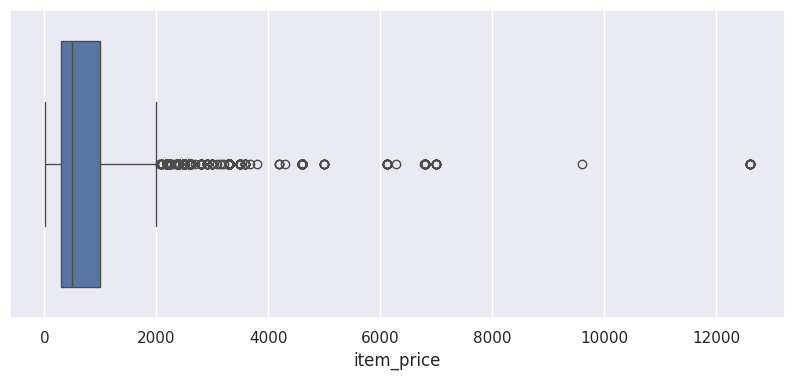

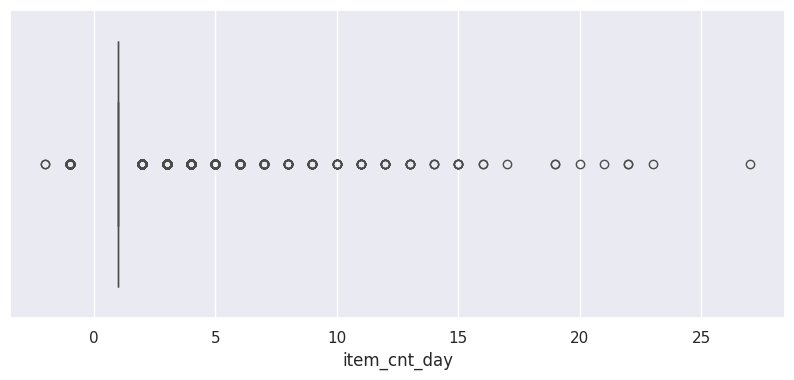

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x=sales['item_price'])

plt.figure(figsize=(10,4))
sns.boxplot(x=sales['item_cnt_day'])

На лицо явные выбросы в данных, очистим датасет от наиболее критичных значений и поближе рассмотрим товары с предополагаемыми выбросами.

In [ ]:
sales = sales[(sales['item_price'] < 50000) & (sales['item_cnt_day'] < 1000)]

<Axes: xlabel='item_cnt_day'>

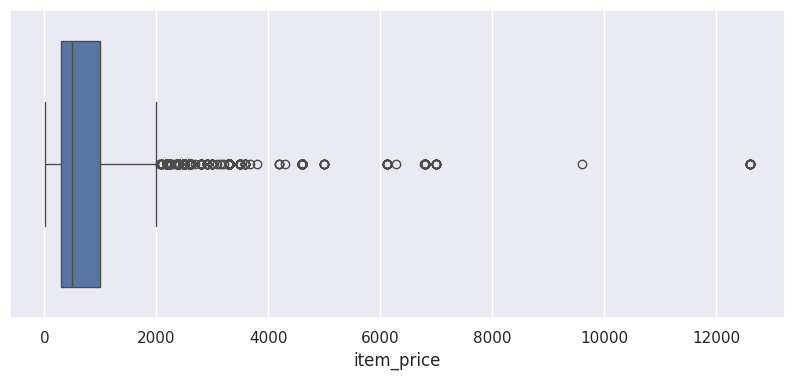

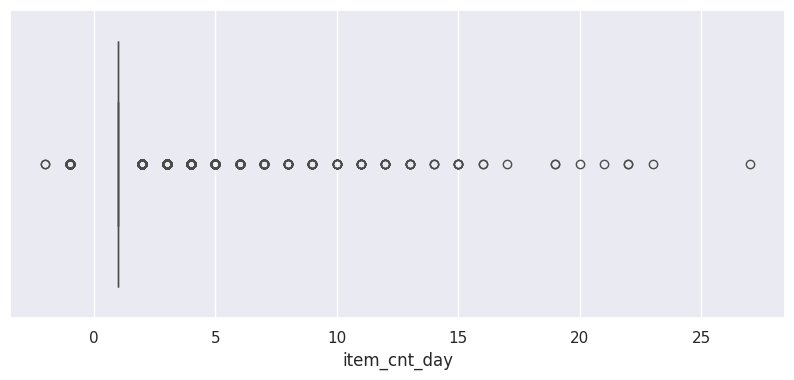

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x=sales['item_price'])

plt.figure(figsize=(10,4))
sns.boxplot(x=sales['item_cnt_day'])

Рассмотрим отрицательные значения в цене:

При анализе состава остальных данных, для простоты понимания добавим подписи для категорий и товаров по их ID

In [ ]:
sales_items = pd.merge(sales, items, on='item_id', how='left')
sales_items = pd.merge(sales_items, item_cat, on='item_category_id', how='left')

In [ ]:
sales_items.sort_values(by='item_price', ascending=False)[['item_price', 'item_cnt_day', 'item_name', 'item_category_name']].head(20)

,item_price,item_cnt_day,item_name,item_category_name
8941,12600.0,1.0,1С:Бухгалтерия 8 ПРОФ. Поставка для розничного...,Программы - 1С:Предприятие 8
1912,12600.0,1.0,1С:Бухгалтерия 8 ПРОФ. Поставка для розничного...,Программы - 1С:Предприятие 8
1911,12600.0,1.0,1С:Бухгалтерия 8 ПРОФ. Поставка для розничного...,Программы - 1С:Предприятие 8
24328,12600.0,1.0,1С:Бухгалтерия 8 ПРОФ. Поставка для розничного...,Программы - 1С:Предприятие 8
24329,12600.0,1.0,1С:Бухгалтерия 8 ПРОФ. Поставка для розничного...,Программы - 1С:Предприятие 8
24330,12600.0,1.0,1С:Бухгалтерия 8 ПРОФ. Поставка для розничного...,Программы - 1С:Предприятие 8
8944,12600.0,1.0,1С:Бухгалтерия 8 ПРОФ. Поставка для розничного...,Программы - 1С:Предприятие 8
8943,12600.0,1.0,1С:Бухгалтерия 8 ПРОФ. Поставка для розничного...,Программы - 1С:Предприятие 8
8942,12600.0,1.0,1С:Бухгалтерия 8 ПРОФ. Поставка для розничного...,Программы - 1С:Предприятие 8
24332,12600.0,1.0,1С:Бухгалтерия 8 ПРОФ. Поставка для розничного...,Программы - 1С:Предприятие 8


Самыми дорогими позициями являются товары из категории Игровых консолей и Программного обеспечения. Они не являются выбросами, удалять такие данные нельзя

In [ ]:
sales_items.sort_values(by='item_cnt_day', ascending=False)[['item_price', 'item_name', 'item_category_name', 'item_cnt_day']].head(20)


,item_price,item_name,item_category_name,item_cnt_day
16586,999.00000,"Diablo III [PC, Jewel, русская версия]",Игры PC - Стандартные издания,27.0
23041,1199.00000,"Crysis 3 [PC, русская версия]",Игры PC - Стандартные издания,23.0
12855,999.00000,"Diablo III [PC, Jewel, русская версия]",Игры PC - Стандартные издания,22.0
23043,1199.00000,"Crysis 3 [PC, русская версия]",Игры PC - Стандартные издания,22.0
23521,1198.97619,"Crysis 3 [PC, русская версия]",Игры PC - Стандартные издания,21.0
9036,299.00000,1С:Управление небольшой фирмой 8. Самоучитель....,Книги - Методические материалы 1С,20.0
23513,1199.00000,"Dead Space 3 [PC, русские субтитры]",Игры PC - Стандартные издания,19.0
6007,599.00000,"DmC Devil May Cry [PC, Jewel, русские субтитры]",Игры PC - Стандартные издания,19.0
3982,399.00000,ОБЛАЧНЫЙ АТЛАС,Кино - DVD,17.0
23528,1199.00000,"Crysis 3 [PC, русская версия]",Игры PC - Стандартные издания,16.0


Большинство самых объёмных покупок производилось через интернет магазины. Данные не являются выбросами, т.к. эти покупки могли совершаться корпоративными клиентами оптом.

Экспресс-анализ данных

Так как требуется помесячный прогноз определим для каждого товара суммарное количество продаж по каждому месяцу:

In [ ]:
group = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_price':['last'], 'item_cnt_day':['sum']})
group.reset_index(inplace=True)
group.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_month']

In [ ]:
group.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month
0,0,2,33,499.0,1.0
1,0,2,482,3300.0,1.0
2,0,2,491,600.0,1.0
3,0,2,839,3300.0,1.0
4,0,2,1007,449.0,3.0


Рассмотрим данные поближе, для этого создадим новый датасет, соержащий текстовое описание id-полей:

In [ ]:
comp_sales = pd.merge(group, items, on='item_id', how='left')
comp_sales = pd.merge(comp_sales, shops, on='shop_id', how='left')
comp_sales = pd.merge(comp_sales, item_cat, on='item_category_id', how='left')
comp_sales['value'] = comp_sales.item_price * comp_sales.item_cnt_month
comp_sales.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,shop_name,city,city_code,item_category_name,cat,subcat,cat_code,subcat_code,value
0,0,2,33,499.0,1.0,1+1 (BD),37,"Адыгея ТЦ ""Мега""",Адыгея,1,Кино - Blu-Ray,Кино,Blu-Ray,11,1,499.0
1,0,2,482,3300.0,1.0,1С:Бухгалтерия 8. Базовая версия,73,"Адыгея ТЦ ""Мега""",Адыгея,1,Программы - 1С:Предприятие 8,Программы,1С:Предприятие 8,15,0,3300.0
2,0,2,491,600.0,1.0,1С:Деньги 8,73,"Адыгея ТЦ ""Мега""",Адыгея,1,Программы - 1С:Предприятие 8,Программы,1С:Предприятие 8,15,0,600.0
3,0,2,839,3300.0,1.0,1С:Упрощенка 8,73,"Адыгея ТЦ ""Мега""",Адыгея,1,Программы - 1С:Предприятие 8,Программы,1С:Предприятие 8,15,0,3300.0
4,0,2,1007,449.0,3.0,3D Crystal Puzzle Замок XL,67,"Адыгея ТЦ ""Мега""",Адыгея,1,Подарки - Развитие,Подарки,Развитие,14,54,1347.0


Рассмотрим линейную взаимосвзяь пар признаков:

<Axes: >

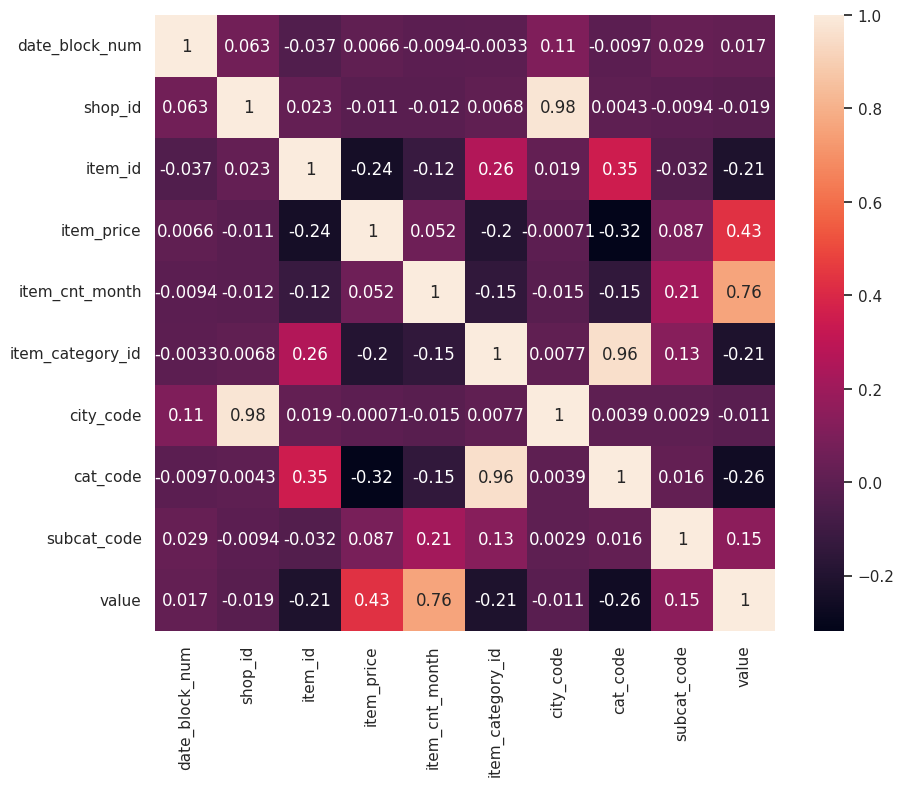

In [ ]:
plt.figure(figsize=(10,8))

sns.heatmap(comp_sales.corr(), annot=True)

Заметна высокая корреляция между признаками "city_code" и 'shop_id', а также "item_category_id" и "cat_code", что не удивительно, ведь это производные одного показателя.

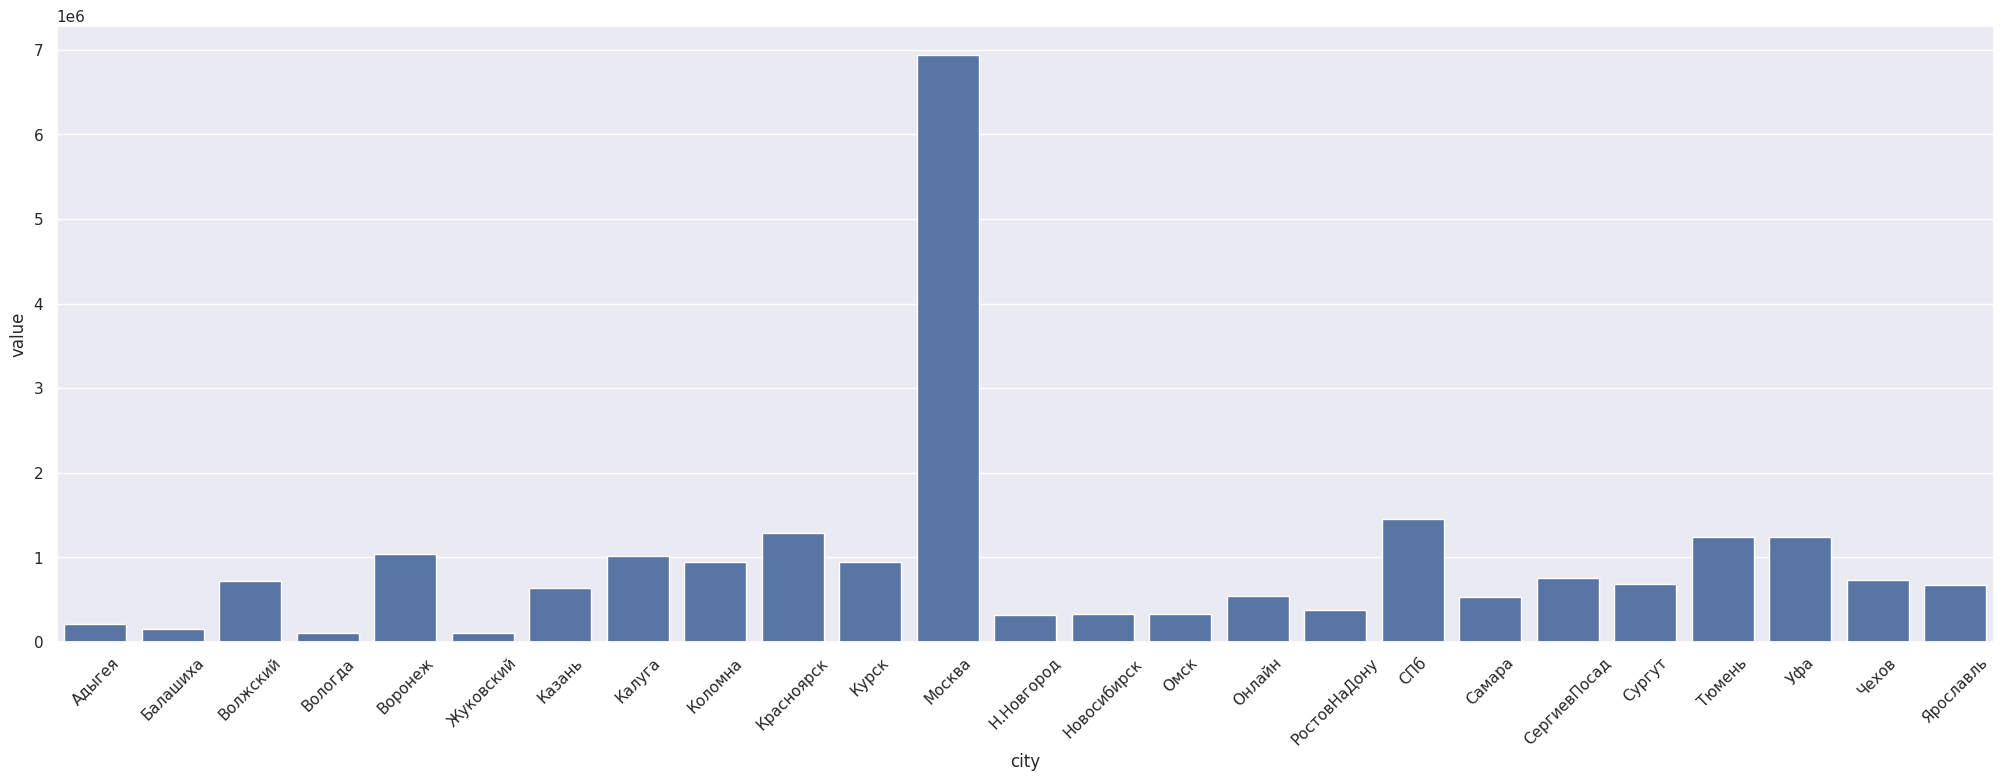

In [ ]:
plt.figure(figsize=(25,8))

sns.barplot(data=comp_sales.groupby(by='city').sum().reset_index(), x="city", y='value')

plt.xticks(rotation=45)
plt.show()

In [ ]:
# количество торговых точек в городах
shops['city'].value_counts().head(15)

Москва          13
Тюмень           3
Воронеж          3
РостовНаДону     3
Уфа              2
Жуковский        2
Онлайн           2
Казань           2
СПб              2
Красноярск       2
Якутск           2
Н.Новгород       2
Новосибирск      2
Самара           2
!Якутск          2
Name: city, dtype: int64

За рассматриваемый период лидером продаж является Москва, на втором месте Тюмень, следом - Воронеж, что во многом обусловлено и количеством торговых точек в данных городах. Это говорит о класической модели ведения бизнеса: большинстов продаж осуществляется через торговые точки и офисы продаж, а не онлайн.

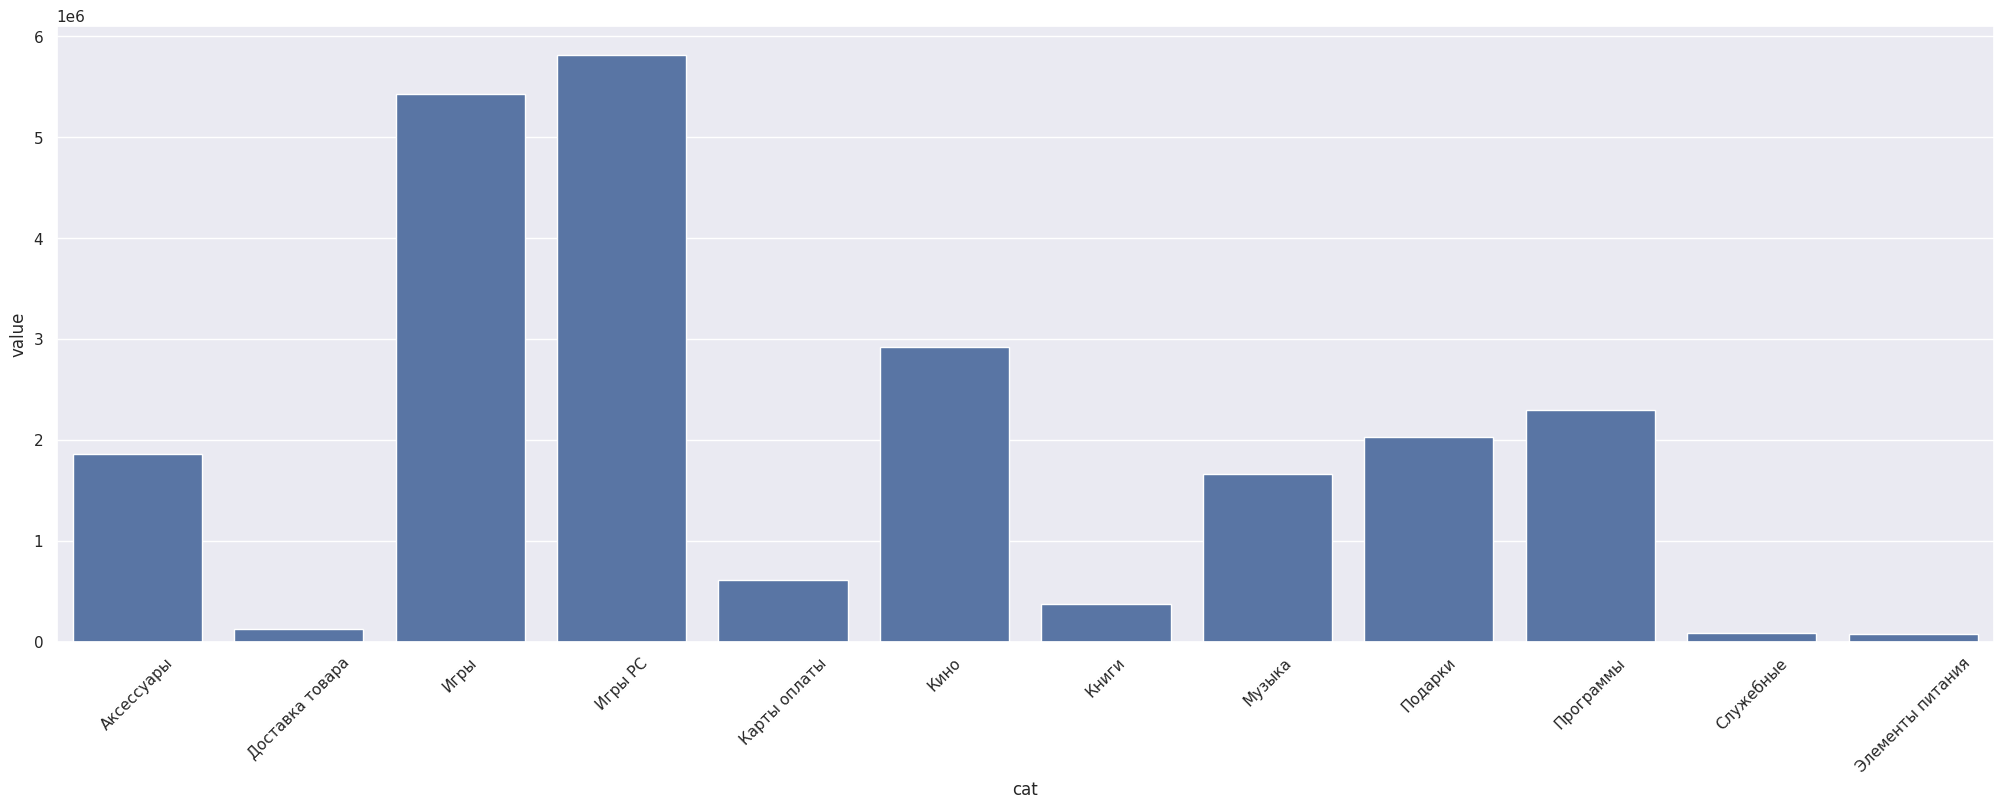

In [ ]:
plt.figure(figsize=(25,8))

sns.barplot(data=comp_sales.groupby(by='cat').sum().reset_index(), x="cat", y='value')

plt.xticks(rotation=45)
plt.show()

Самая продаваемая категория - это игры и игровые консоли.

Топ 20 самых продаваемых товаров:

In [ ]:
comp_sales.groupby(by='item_name').sum()['item_category_id'].sort_values(ascending=False).head(20)

item_name
Прием денежных средств для 1С-Онлайн                         2844
Элемент питания DURACELL LR06-BC2                            2822
Элемент питания DURACELL TURBO LR6 2*BL                      2739
Dr.Web Security Space КЗ 2 ПК/2 года (картонная упаковка)    2700
Элемент питания DURACELL LR03-BC2                            2656
1С:Бухгалтерия 8. Базовая версия                             2482
Магический шар 8 оригинальный                                2415
Настольная игра Морской бой Для путешествий                  2275
ADELE  21                                                    2255
FARMER MYLENE  Monkey Me                                     2255
ЛЕПС ГРИГОРИЙ  Полный вперед (фирм.)                         2255
Настольная игра Уно                                          2210
ЛЕПС ГРИГОРИЙ  The Best  3CD (фирм.)                         2200
GREEN DAY  Tre                                               2200
Неокуб, 5мм, Альфа 216, Стальной                             2077


Топ 20 самых непопулярных товаров:

In [ ]:
comp_sales.groupby(by='item_name').sum()['item_category_id'].sort_values(ascending=False).tail(20)

item_name
МУВИ 43 (BD)                                                                           37
ПОСЛЕЗАВТРА (BD)                                                                       37
КРАСНАЯ ШАПОЧКА WB (BD)                                                                37
КОРОЛЬ ЛЕВ 3 АКУНА МАТАТА (BD+DVD)                                                     37
СТАЛЬНАЯ БАБОЧКА (BD)                                                                  37
БЕРЕМЕННЫЙ (BD)                                                                        37
СКАЗКА. ЕСТЬ (BD)                                                                      37
ВЛАСТЕЛИН КОЛЕЦ: БРАТСТВО КОЛЬЦА WB (BD)                                               37
ПАПАШИ БЕЗ ВРЕДНЫХ ПРИВЫЧЕК (BD)                                                       37
ВЛАСТЕЛИН КОЛЕЦ: ВОЗВРАЩЕНИЕ КОРОЛЯ WB (BD)                                            37
ВОЙНА БОГОВ:БЕССМЕРТНЫЕ (BD)                                                           37


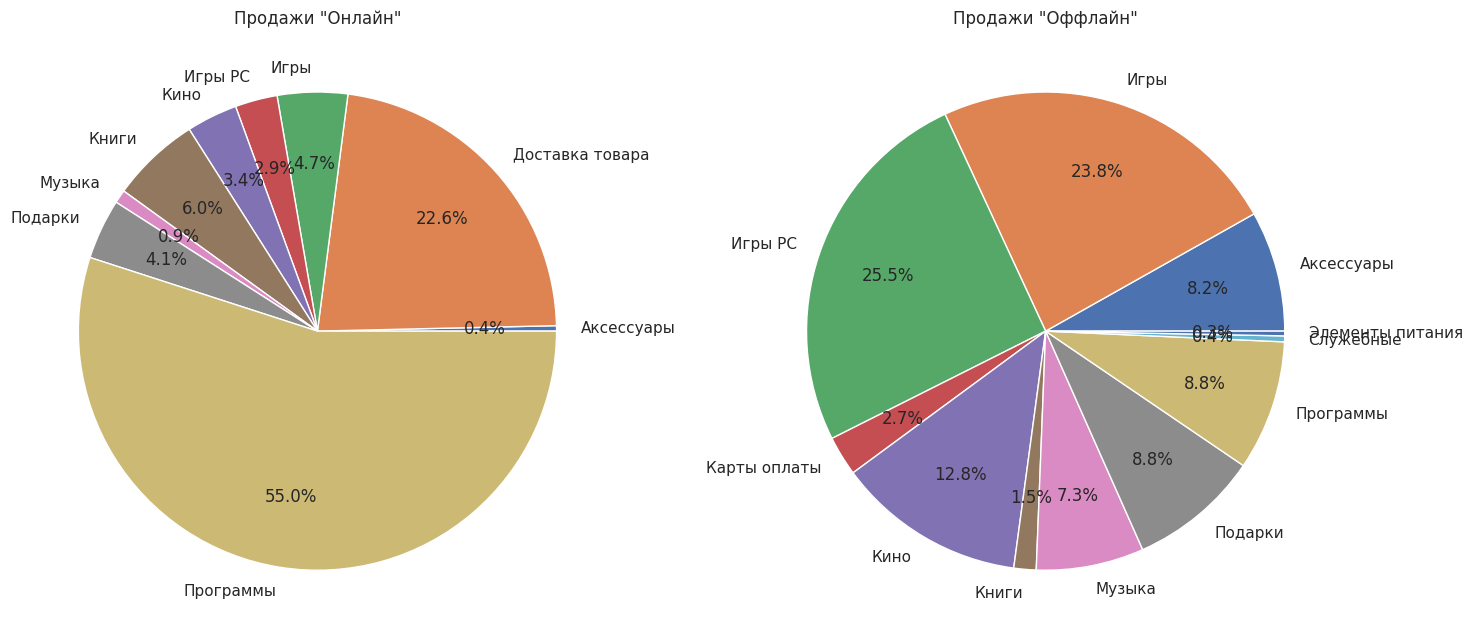

In [ ]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (15,10))

online = comp_sales[comp_sales['city'] == 'Онлайн'].groupby(by='cat').sum()['value']

axes[0].set_title('Продажи "Онлайн"')
axes[0].pie(x=online, autopct="%.1f%%", labels=online.index, pctdistance=0.7)

offline = comp_sales[comp_sales['city'] != 'Онлайн'].groupby(by='cat').sum()['value']

axes[1].set_title('Продажи "Оффлайн"')
axes[1].pie(x=offline, autopct="%.1f%%", labels=offline.index, pctdistance=0.7)

plt.tight_layout()
plt.show()

В сфере онлайн покупок доминириуют Игры, Игровые консоли и Игры PC, похожая ситуация и с Оффлайн продажами, однако, доля продаж игровых консолей меньше, при этом весомую часть занимают Подарки, в Онлайн сегменте также можно выделить большую долю продаж Карт оплат и Программ, а также доставку. При этом доля оплаты за доставку превышает стоимость продаж большинства групп товаров.

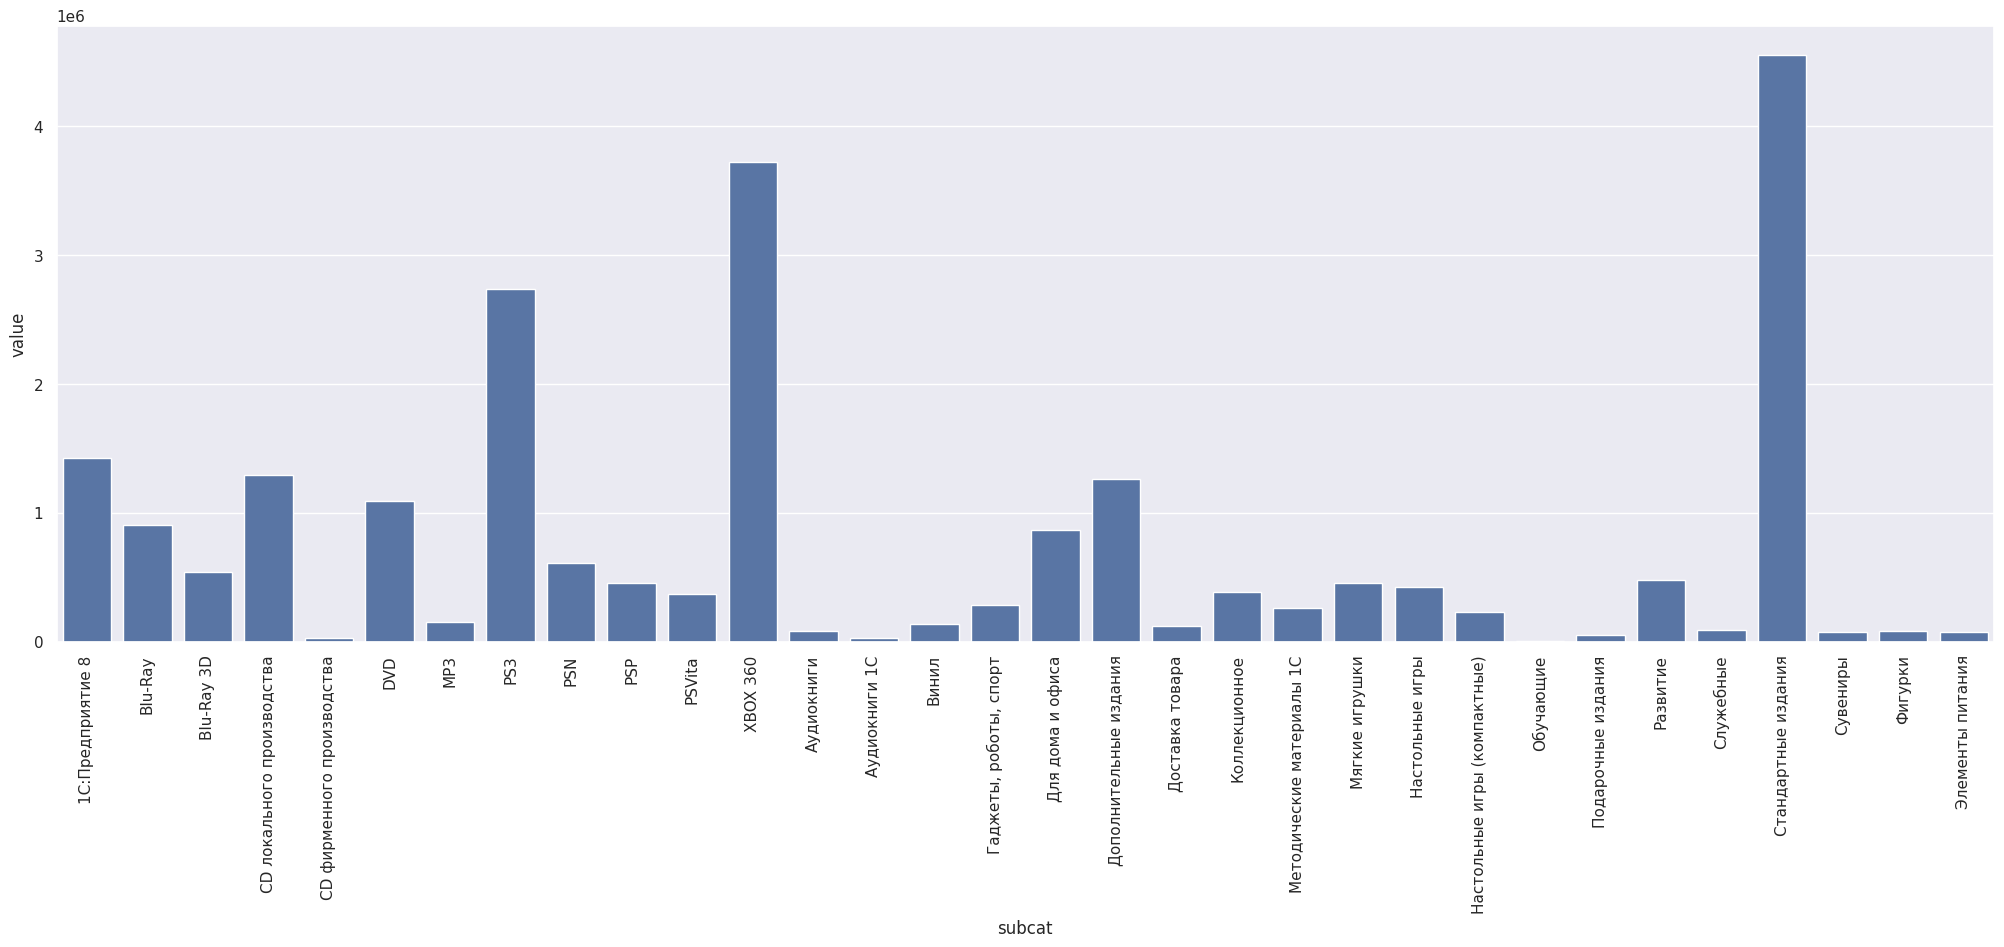

In [ ]:
plt.figure(figsize=(25,8))
sns.barplot(data=comp_sales.groupby(by='subcat').sum().reset_index(), x="subcat", y='value')
plt.xticks(rotation=90)
plt.show()

Лидерами продаж выстуапают консоли от Sony и игры к ним.

Рассмотрим динамику продаж по месяцам:

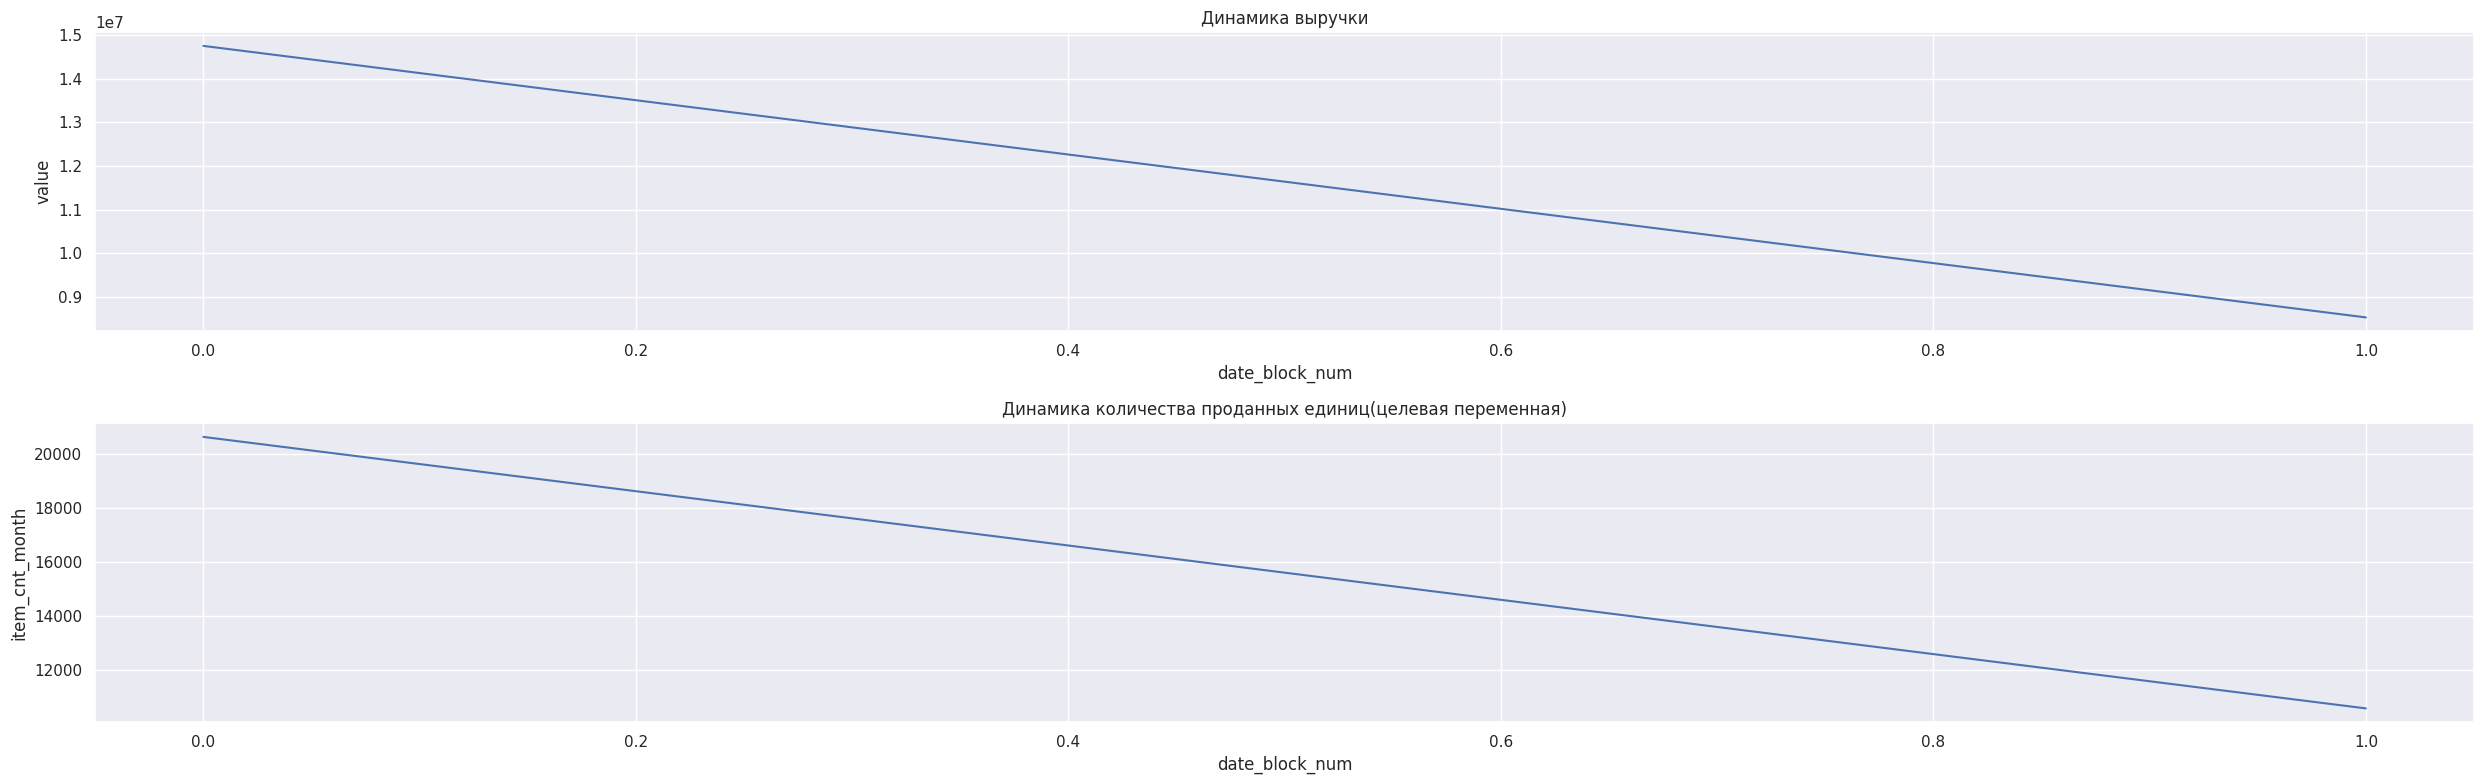

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(25,8))

axes[0].set_title('Динамика выручки')
sns.lineplot(data=comp_sales.groupby(by='date_block_num').sum().reset_index(), x="date_block_num", y='value', ax=axes[0])

axes[1].set_title('Динамика количества проданных единиц(целевая переменная)')
sns.lineplot(data=comp_sales.groupby(by='date_block_num').sum().reset_index(), x="date_block_num", y='item_cnt_month', ax=axes[1])

plt.tight_layout()
plt.show()

Наблюдается восходящий тренд, а также явные пиковые точки продаж. Предположительно это связано с новгодними праздниками. Проверим:

In [ ]:
comp_sales.groupby(by='date_block_num').sum().sort_values(by='value', ascending=False)['value'].head(2)

date_block_num
0    1.475388e+07
1    8.534833e+06
Name: value, dtype: float64

Учитывая, что нумерация месяцев начинается с 0 и с 1-го января 2013 года, то 23 и 11 месяц это декабрь 2014 и декабрь 2013 соотвественно.

Text(0.5, 1.0, 'Динамика продаж по категориям')

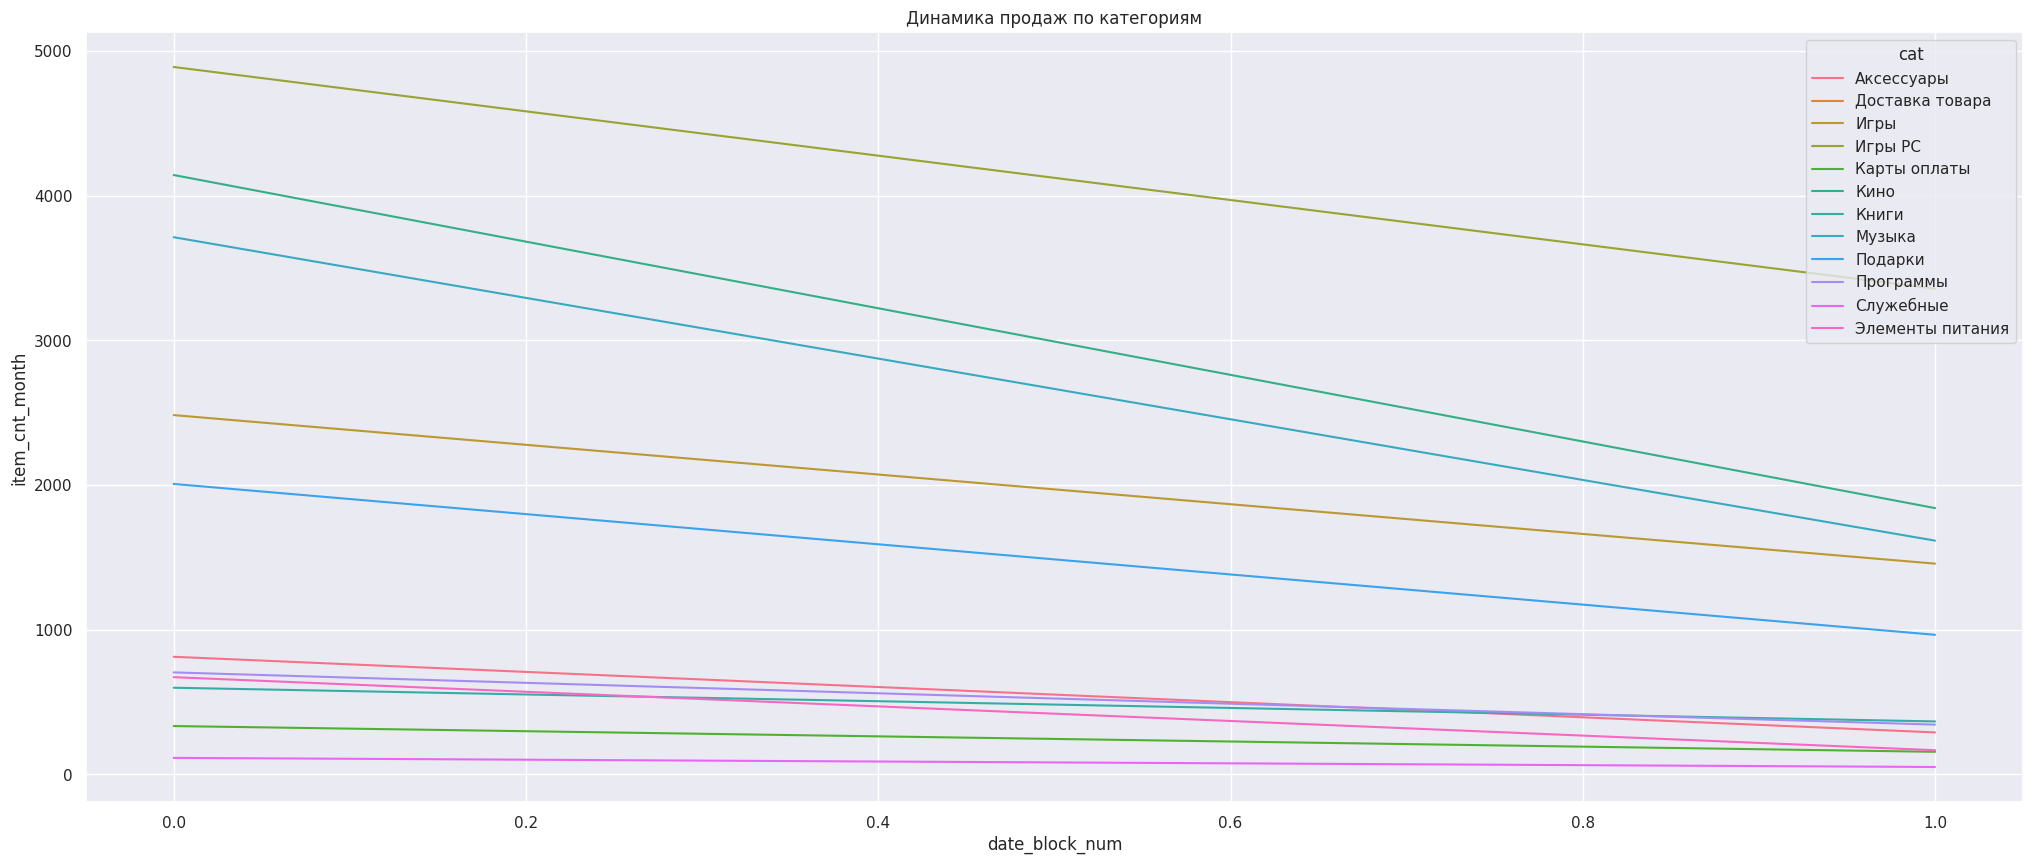

In [ ]:
plt.figure(figsize=(25,10))

sns.lineplot(data=comp_sales.groupby(by=['date_block_num', 'cat']).sum().reset_index(), x='date_block_num', y='item_cnt_month', hue='cat')

plt.title('Динамика продаж по категориям')

Наблюдается восходящий тренд на самые популярные товары, также наиболее яркие пики продаж заметны в декабре. Стоит обратить внимание и на периодические большие скачки продаж по играм, причиной могут быть сезонные распродажи от издателей или премьеры новых продуктов.

Подготовка данных

In [ ]:
prp_sales = comp_sales[['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'item_price']]
prp_sales.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price
0,2,33,0,1.0,499.0
1,2,482,0,1.0,3300.0
2,2,491,0,1.0,600.0
3,2,839,0,1.0,3300.0
4,2,1007,0,3.0,449.0


Как мы видели выше, распределение продаж по точкам не однородно, следовательно вероятны ситуации, когда какой-то товар не продавался в магазине в определённом периоде. Для повышения качества прогноза, необходимо явно выделить такие ситуации, для этого необходимо расширить наш датасет и включить в него все возможные комбинации 'item_id' и 'shop_id' помесячно

In [ ]:
from itertools import product # функция возвращает все возможные комбинации итерируемых элементов

In [ ]:
inter_matrix = []

for month in prp_sales['date_block_num'].unique():
    shops_in_month = prp_sales.loc[prp_sales['date_block_num'] == month, 'shop_id'].unique()
    items_in_month = prp_sales.loc[prp_sales['date_block_num'] == month, 'item_id'].unique()
    inter_matrix.append(np.array(list(product(*[shops_in_month, items_in_month, [month]])), dtype='int32'))

In [ ]:
inter_matrix[:2]

[array([[    2,    33,     0],
        [    2,   482,     0],
        [    2,   491,     0],
        ...,
        [   59, 14163,     0],
        [   59, 14272,     0],
        [   59, 14406,     0]], dtype=int32),
 array([[    3,  2808,     1],
        [    3, 14252,     1],
        [    3, 14313,     1],
        ...,
        [   59, 21358,     1],
        [   59, 21536,     1],
        [   59, 21843,     1]], dtype=int32)]

In [ ]:
# стыкуем массивы в общий массив
inter_matrix = np.vstack(inter_matrix)
inter_matrix = pd.DataFrame(inter_matrix, columns=['shop_id', 'item_id', 'date_block_num'])
inter_matrix.shape

(48300, 3)

Добавим в полученную матрицу значения месячных продаж для каждой комбинации Пропуски заполним нулями, и ограничим значения целевой переменной интервалом (0,20), чтобы приблизить к условиям задачи.

In [ ]:
prp_sales = pd.merge(inter_matrix, prp_sales, on=['shop_id', 'item_id', 'date_block_num'], how='left')
prp_sales['item_cnt_month'] = prp_sales['item_cnt_month'].fillna(0).clip(0,20)
prp_sales['item_price'] = prp_sales['item_price'].fillna(0)

In [ ]:
print("Пропущенных значений: ", prp_sales['item_cnt_month'].isna().sum())
print("Максимальное значение целевой переменной: ",prp_sales['item_cnt_month'].max())

Пропущенных значений:  0
Максимальное значение целевой переменной:  20.0


Теперь необходимо добавить в итоговую матрицу основные метки связанные с товаром: магазины, категория, цена и т.д.

In [ ]:
prp_sales = pd.merge(prp_sales, items, on='item_id', how='left')
prp_sales = pd.merge(prp_sales, shops, on='shop_id', how='left')
prp_sales = pd.merge(prp_sales, item_cat, on='item_category_id', how='left')
prp_sales = prp_sales.drop(['item_name', 'shop_name', 'city', 'item_category_name', 'cat', 'subcat'], axis=1)
# добавим цену
prp_sales.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_category_id,city_code,cat_code,subcat_code
0,2,33,0,1.0,499.0,37,1,11,1
1,2,482,0,1.0,3300.0,73,1,15,0
2,2,491,0,1.0,600.0,73,1,15,0
3,2,839,0,1.0,3300.0,73,1,15,0
4,2,1007,0,3.0,449.0,67,1,14,54


In [ ]:
prp_sales.shape

(48300, 9)

Заодно приведём к такому же виду набор данных для предсказаний:

In [ ]:
test = pd.merge(test, items[['item_id','item_category_id']], on='item_id', how='left')
test = pd.merge(test, item_cat[['item_category_id', 'cat_code', 'subcat_code']], on='item_category_id', how='left')
test = pd.merge(test, shops[['shop_id', 'city_code']], on='shop_id', how='left')
test['item_cnt_month'] = 0
test.head()

,shop_id,item_id,date_block_num,item_price,item_category_id,cat_code,subcat_code,city_code,item_cnt_month
0,5,5037,34,1252.491603,19,5,12,4,0
1,5,5320,34,274.782513,55,13,4,4,0
2,5,5233,34,1252.491603,19,5,12,4,0
3,5,5232,34,1716.761094,23,5,18,4,0
4,5,5268,34,686.956087,20,5,13,4,0


Теперь объденим тестовый дасет и датасет продаж:

In [ ]:
new_sales = prp_sales.append(test)

Для качественного построения моделей временного ряда необходимо учитывать зависимость между настоящими и прошлыми значениями уровней данного ряда, это нужно для прогнозирования тренда или сезонности.

Лагом называется величина сдвига между рядами наблюдений.

Зададим временные лаги для ряда признаков. Будем сдвигать периоды помесячно до полугода и на год. Такой охват поможет оценить как трендовую зависимость так и сезонность.

In [ ]:
def generate_lag(data, months, lag_column):

    """Функция добавляет лаги в целевой признак. Принимает на вход датасет, величину сдвига и сам целевой признак"""

    for month in months:

        data_shift = data[['date_block_num', 'shop_id', 'item_id', lag_column]].copy()
        data_shift.columns = ['date_block_num', 'shop_id', 'item_id', lag_column + '_lag_' + str(month)]
        data_shift['date_block_num'] += month
        data = pd.merge(data, data_shift, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return data

Целевой лаг:

In [ ]:
%%time
new_sales = generate_lag(new_sales, [1,2,3,6,12], 'item_cnt_month')

CPU times: user 505 ms, sys: 115 ms, total: 621 ms
Wall time: 616 ms


In [ ]:
# Сдвиг среднемесячных продаж по товарам:
group = new_sales.groupby(['date_block_num', 'item_id'])['item_cnt_month'].mean().rename('item_month_mean').reset_index()
new_sales = pd.merge(new_sales, group, on=['date_block_num', 'item_id'], how='left')
new_sales = generate_lag(new_sales, [1,2,3,6,12], 'item_month_mean')
new_sales.drop(['item_month_mean'], axis=1, inplace=True)

In [ ]:
# Сдвиг среднемесячных продаж по магазинам:
group = new_sales.groupby(['date_block_num', 'shop_id'])['item_cnt_month'].mean().rename('shop_month_mean').reset_index()
new_sales = pd.merge(new_sales, group, on=['date_block_num', 'shop_id'], how='left')
new_sales = generate_lag(new_sales, [1,2,3,6,12], 'shop_month_mean')
new_sales.drop(['shop_month_mean'], axis=1, inplace=True)

In [ ]:
# Сдвиг среднемесячных продаж по категориям:
group = new_sales.groupby(['date_block_num', 'cat_code'])['item_cnt_month'].mean().rename('cat_code_month_mean').reset_index()
new_sales = pd.merge(new_sales, group, on=['date_block_num', 'cat_code'], how='left')
new_sales = generate_lag(new_sales, [1,2,3,6,12], 'cat_code_month_mean')
new_sales.drop(['cat_code_month_mean'], axis=1, inplace=True)

In [ ]:
# Сдвиг среднемесячных продаж по магазинам/категориям:
group = new_sales.groupby(['date_block_num', 'shop_id', 'item_category_id'])['item_cnt_month'].mean().rename('shop_category_month_mean').reset_index()
new_sales = pd.merge(new_sales, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
new_sales = generate_lag(new_sales, [1,2,3,6,12], 'shop_category_month_mean')
new_sales.drop(['shop_category_month_mean'], axis=1, inplace=True)

In [ ]:
new_sales.fillna(0, inplace=True)

In [ ]:
new_sales.shape

(262500, 34)

In [ ]:
new_sales.tail()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_category_id,city_code,cat_code,subcat_code,item_cnt_month_lag_1,...,cat_code_month_mean_lag_1,cat_code_month_mean_lag_2,cat_code_month_mean_lag_3,cat_code_month_mean_lag_6,cat_code_month_mean_lag_12,shop_category_month_mean_lag_1,shop_category_month_mean_lag_2,shop_category_month_mean_lag_3,shop_category_month_mean_lag_6,shop_category_month_mean_lag_12
262495,45,18454,34,0.0,274.782513,55,21,13,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262496,45,16188,34,0.0,893.395640,64,21,14,44,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262497,45,15757,34,0.0,199.000000,55,21,13,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262498,45,19648,34,0.0,266.199748,40,21,11,6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
262499,45,969,34,0.0,563.693684,37,21,11,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


** XGBoost

В основе XGBoost лежит алгоритм градиентного бустинга деревьев решений. Градиентный бустинг — это техника машинного обучения для задач классификации и регрессии, которая строит модель предсказания в форме ансамбля слабых предсказывающих моделей, обычно деревьев решений. Считается одной из самых эффективных реализаций градиентного бустинга.

Перед использованием модели разделим нашу выборку на обучающую, валидационную и тестовую(в рамках этого задания - целевую).

In [ ]:
x_train = new_sales[new_sales.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = new_sales[new_sales.date_block_num < 33]['item_cnt_month']

x_valid = new_sales[new_sales.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = new_sales[new_sales.date_block_num == 33]['item_cnt_month']

x_test = new_sales[new_sales.date_block_num == 34].drop(['item_cnt_month'], axis=1)

Реализуем модель на основе XGBoost.

In [ ]:
%%time
model = xgb.XGBRegressor(
    n_estimators = 1000,
    learning_rate = 0.1,
    max_depth = 10,
    subsample = 0.5,
    colsample_bytree = 0.5)

model.fit(
    x_train,
    y_train,
    eval_metric='rmse',
    eval_set=[(x_train, y_train),
               (x_valid, y_valid)],
    verbose=True,
    early_stopping_rounds=10,
          )

[0]	validation_0-rmse:1.80637	validation_1-rmse:0.00000
[1]	validation_0-rmse:1.69794	validation_1-rmse:0.00000
[2]	validation_0-rmse:1.64049	validation_1-rmse:0.00000
[3]	validation_0-rmse:1.55858	validation_1-rmse:0.00000
[4]	validation_0-rmse:1.48572	validation_1-rmse:0.00000
[5]	validation_0-rmse:1.44969	validation_1-rmse:0.00000
[6]	validation_0-rmse:1.37610	validation_1-rmse:0.00000
[7]	validation_0-rmse:1.31954	validation_1-rmse:0.00000
[8]	validation_0-rmse:1.27031	validation_1-rmse:0.00000
[9]	validation_0-rmse:1.24008	validation_1-rmse:0.00000
CPU times: user 447 ms, sys: 27.7 ms, total: 475 ms
Wall time: 307 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# предсказания для оценочного набора данных
predictions = model.predict(x_test).clip(0,20)

# предсказание для валидационного набора данных
pred_val = model.predict(x_valid)

In [ ]:
model.best_score

0.0

Ошибка довольно низкая.

Визуализируем прогноз на валидационных данных

<Axes: >

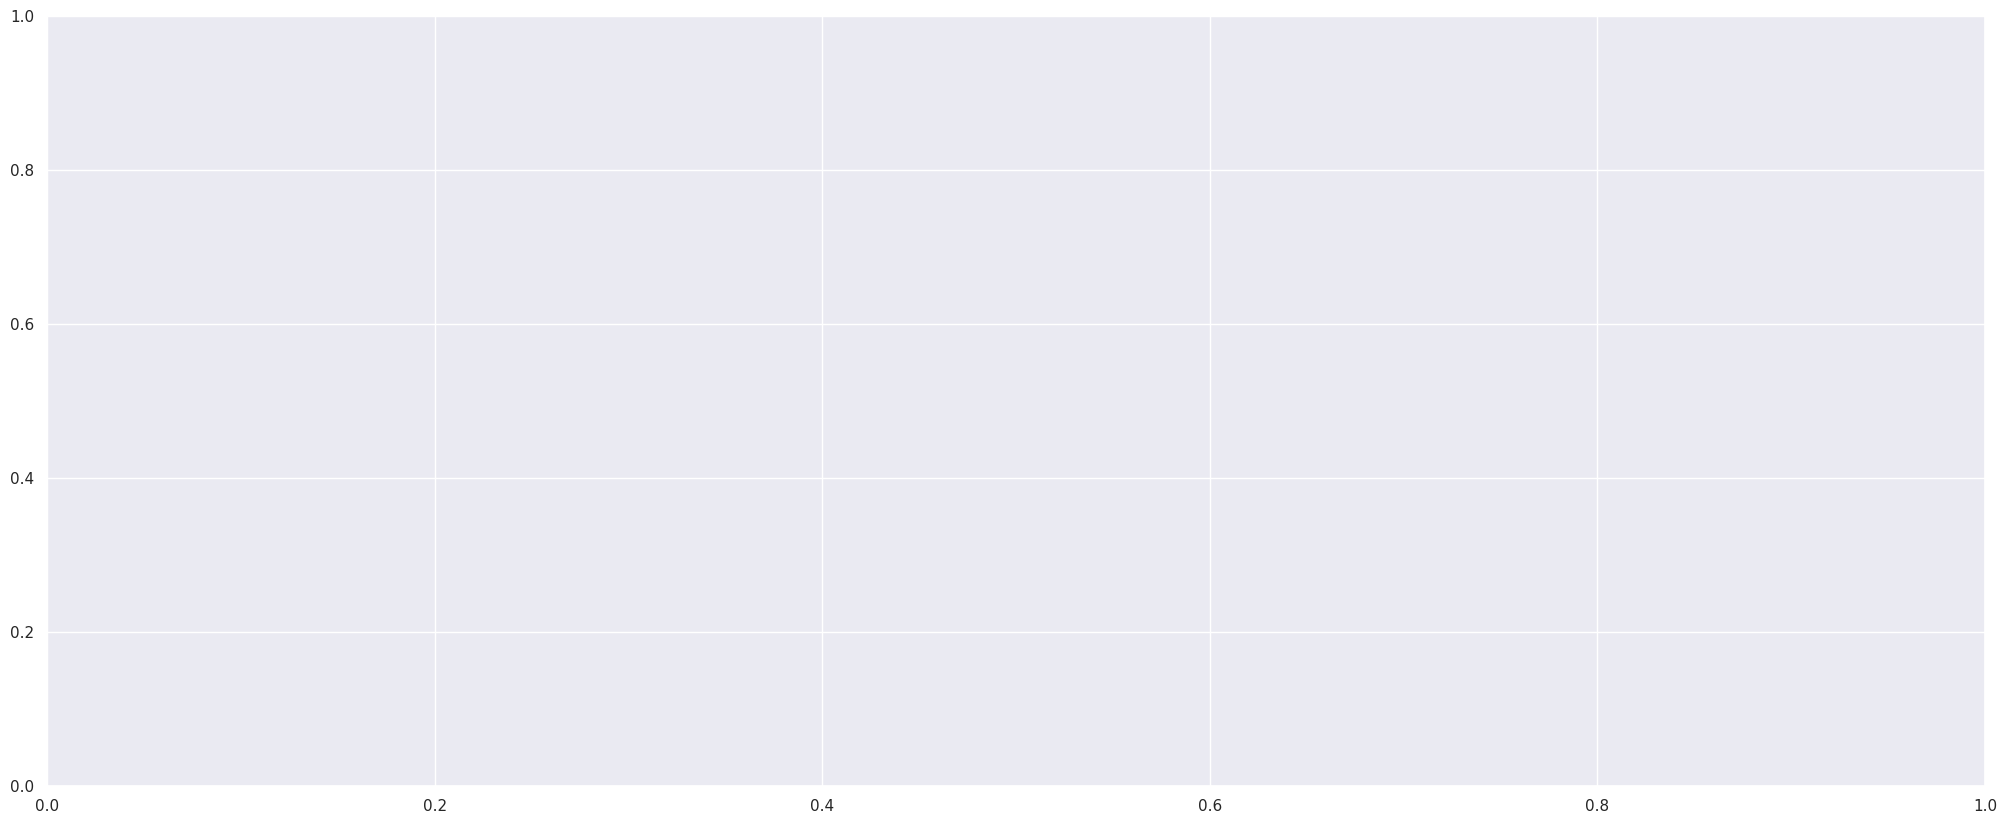

In [ ]:
plt.figure(figsize=(25,10))

sns.lineplot(x=x_valid.index, y=pred_val)
sns.lineplot(x=x_valid.index, y=y_valid, alpha=0.6)

График прогноза довольно близко повторяет истинные значения. К тому же ошибка на валидации довольно низка - модель можно использовать для прогноза.

Рассмотри оценку значимости признаков:

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

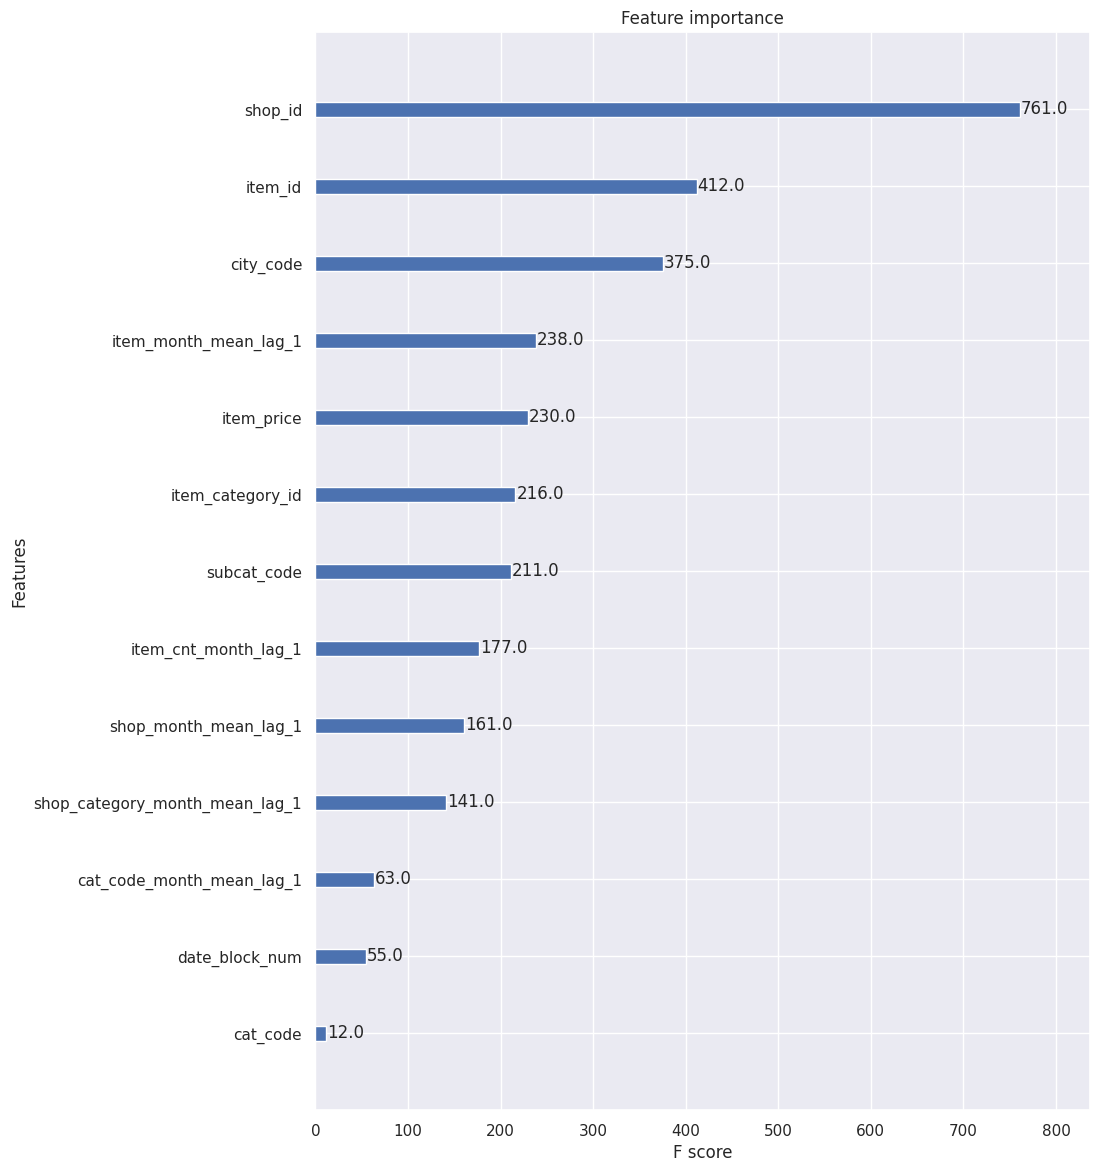

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,14))
xgb.plot_importance(model, ax=ax)

Признаки со сдвигами довольно сильно влияют на итоговый результат.

Сохраним результат прогноза в файл:

In [ ]:
submission = pd.DataFrame({
    "ID": test.index,
    "item_cnt_month": predictions
})
submission.to_csv('submission.csv', index=False)